In [137]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

In [138]:
from gensim.models import KeyedVectors
w2v_path = "../../corpus/w2v/"
# fasttext
# https://qiita.com/Hironsan/items/513b9f93752ecee9e670
# w2v_name =  "dep-ja-300dim"
w2v_name =  "model.vec"
w2v_model = KeyedVectors.load_word2vec_format(w2v_path+w2v_name)

[589] 2022-01-06 00:21:38,039 Info gensim.models.keyedvectors :loading projection weights from ../../corpus/w2v/model.vec
[589] 2022-01-06 00:22:39,574 Info gensim.utils :KeyedVectors lifecycle event {'msg': 'loaded (351122, 300) matrix of type float32 from ../../corpus/w2v/model.vec', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-01-06T00:22:39.574330', 'gensim': '4.0.1', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.72-microsoft-standard-WSL2-x86_64-with-Ubuntu-18.04-bionic', 'event': 'load_word2vec_format'}


In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

In [140]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [141]:
# csv 読み込み
group_filename = "../../corpus/case_frame/easy_group.csv"


In [164]:
import csv
group_dict = dict()
key_list = []
with open(group_filename, mode="r") as f:
    reader = csv.reader(f)
    for row in reader:
        group_key = row[0]
        key_list.append(group_key)
        group_dict[group_key] = set()
        for w in row[1:]:
            if w == "":
                continue
            group_dict[group_key].add(w)

In [165]:
group_key

'<複文>'

In [166]:
group_filename

'../../corpus/case_frame/easy_group.csv'

In [193]:
border = 0.8
for group_key in tqdm(group_dict.keys()):
    similar_set = set()
    if group_key=="<複文>":
        continue
    for w in group_dict[group_key]:
        w = clean_text(w)
        if w not in w2v_model:
            continue
        sim_list = w2v_model.most_similar(w)
        for sim in sim_list:
            if sim[1] > border:
                similar_set.add(sim[0])

    # break
    group_dict[group_key].update(similar_set)
    

100%|██████████| 86/86 [00:34<00:00,  2.52it/s]


In [194]:
dict_path = "../models/utterance/"
dict_name = "group_border={0}_2.pickle".format(border)
dictM = DataManager(dict_path)
dictM.save_data(dict_name, group_dict)

success save : ../models/utterance/group_border=0.8_2.pickle


In [195]:
label_dict = dict(zip( group_dict.keys(), range(len(group_dict.keys())) ))

In [196]:
label_dict

{'<ヒト>': 0,
 '<ヒト（数）>': 1,
 '<ヒト（役割）>': 2,
 '<ヒト（組織）>': 3,
 '<敬称>': 4,
 '<ヒト（要素）>': 5,
 '<指示代名詞>': 6,
 '<動物>': 7,
 '<動物（要素）>': 8,
 '<植物>': 9,
 '<時間>': 10,
 '<日付>': 11,
 '<時刻>': 12,
 '<頻度>': 13,
 '<時間表現>': 14,
 '<時期>': 15,
 '<時間（単位）>': 16,
 '<季節>': 17,
 '<曜日>': 18,
 '<場所>': 19,
 '<場所（接尾辞）>': 20,
 '<方向>': 21,
 '<位置>': 22,
 '<建物>': 23,
 '<建物（接尾辞）>': 24,
 '<建物（要素）>': 25,
 '<家具>': 26,
 '<環境>': 27,
 '<乗り物>': 28,
 '<乗り物（要素）>': 29,
 '<もの>': 30,
 '<道具>': 31,
 '<器>': 32,
 '<機械>': 33,
 '<装飾品>': 34,
 '<楽器>': 35,
 '<普遍語>': 36,
 '<状況>': 37,
 '<傾向>': 38,
 '<ゴール>': 39,
 '<様子>': 40,
 '<規則>': 41,
 '<保証>': 42,
 '<変化>': 43,
 '<目的>': 44,
 '<存在・関係>': 45,
 '<活動>': 46,
 '<サイズ>': 47,
 '<管理行動>': 48,
 '<災害>': 49,
 '<イベント>': 50,
 '<量>': 51,
 '<数字>': 52,
 '<単位>': 53,
 '<考え>': 54,
 '<心理>': 55,
 '<理由>': 56,
 '<感覚>': 57,
 '<状態>': 58,
 '<病気>': 59,
 '<線>': 60,
 '<通信網>': 61,
 '<インフラ>': 62,
 '<視覚>': 63,
 '<音>': 64,
 '<言語>': 65,
 '<太陽>': 66,
 '<降水>': 67,
 '<流体>': 68,
 '<文字>': 69,
 '<文書>': 70,
 '<色>': 71,
 '<スポーツ>': 72,
 '

In [197]:
def make_Xy_frame(group_dict:dict, w2v_model:KeyedVectors):
    X = []
    y = []
    
    for la, group_key in tqdm(enumerate(group_dict.keys())):
        for x in group_dict[group_key]:
            # 複文は無視
            if la==85:
                break
            if x not in w2v_model:
                continue
            X.append(  w2v_model[x] )
            y.append(la)
    
    return torch.tensor(X), torch.tensor(y)

In [198]:
X, y = make_Xy_frame(group_dict, w2v_model)
len(X)

86it [00:00, 18363.29it/s]


1986

In [199]:
for i in range(85):
    if len( torch.where(y==i)[0] )==1:
        print(i)
    

In [200]:
torch.where(y==4)[0]


tensor([229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
        243, 244, 245, 246, 247, 248])

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5, stratify=y)

In [202]:
class CaseModel(nn.Module):
    def __init__(self, embedding_dim, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(CaseModel, self).__init__()    
        self.embedding_dim = embedding_dim
        self.hid1= embedding_dim*2
        self.hid2 = embedding_dim//2
        self.fc1 = nn.Linear(self.embedding_dim, self.hid1)
        self.fc2 = nn.Linear(self.hid1, self.hid2)
        self.hidden2tag = nn.Linear(self.hid2, tagset_size)
    
    def forward(self, x):
        y = F.relu(self.fc1(x))
        y = F.relu(self.fc2(y))
        y = self.hidden2tag( y )
        y = F.log_softmax(y, dim=1)
        return y

In [203]:
EMBEDDING_DIM = 300
HIDDEN_DIM = EMBEDDING_DIM*2
OUTPUT_DIM = len(label_dict)-1
# seq_len = length
print(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

300 600 85


In [204]:
BATCH_SIZE = 32
epoch_ = 600
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [205]:
model = CaseModel(EMBEDDING_DIM, OUTPUT_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [206]:
losses = []
for epoch in range(epoch_): 
    all_loss = 0
    for data in trainloader:
        X_t_tensor = data[0].cuda()
        y_t_tensor = data[1].cuda()
        optimizer.zero_grad()
        model.zero_grad()
        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

epoch 50 	 loss 63.07888847589493
epoch 100 	 loss 30.05609580874443
epoch 150 	 loss 16.608931183815002
epoch 200 	 loss 10.727368496358395
epoch 250 	 loss 8.142878141254187
epoch 300 	 loss 7.083655476570129
epoch 350 	 loss 6.549826992675662
epoch 400 	 loss 6.1601252146065235
epoch 450 	 loss 5.894880257546902
epoch 500 	 loss 5.838132738135755
epoch 550 	 loss 5.763195991516113
epoch 600 	 loss 5.7323508486151695
done


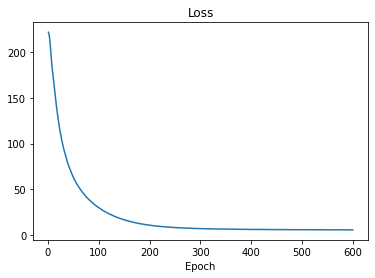

In [207]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [208]:
with torch.no_grad():
    X_tensor = X_test.cuda()
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

In [209]:
def score(test, pred):
    if len(collections.Counter(pred)) <= 2:
        print('confusion matrix = \n', confusion_matrix(y_true=test, y_pred=pred))
        print('accuracy = ', accuracy_score(y_true=test, y_pred=pred))
        print('precision = ', precision_score(y_true=test, y_pred=pred))
        print('recall = ', recall_score(y_true=test, y_pred=pred))
        print('f1 score = ', f1_score(y_true=test, y_pred=pred))
    else:
        print('confusion matrix = \n', confusion_matrix(y_true=test, y_pred=pred))
        print('accuracy = ', accuracy_score(y_true=test, y_pred=pred))

In [210]:
score(y_test, y_pred)

confusion matrix = 
 [[16  1  1  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 11  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  

In [211]:
np.set_printoptions(threshold=np.inf)

In [212]:
model_path = "../models/utterance/"
model_name = "case_frame_{0}_2.pickle".format(border)
modelM = DataManager(model_path)
modelM.save_data(model_name, model)

success save : ../models/utterance/case_frame_0.8_2.pickle
